In [2]:
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, recall_score
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
import sqlite3
import pandas as pd
from keras.callbacks import EarlyStopping
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor

In [44]:
conn = sqlite3.connect(r'C:\Users\spiri\codingbootcamp\Final-project-C4Y\data.db')
cursor = conn.cursor()
query = ('''WITH sum_balance as (
    select 
         client_id,
         SUM(balance) as sum_balance,
         currency
    from balances
    group by 1
)
Select inv_campaign_eval.client_id, inv_campaign_eval.poutcome, sum_balance.sum_balance, sum_balance.currency 
from inv_campaign_eval
left join sum_balance
on inv_campaign_eval.client_id = sum_balance.client_id''')
df = pd.read_sql_query(query, conn)

df

,client_id,poutcome,sum_balance,currency
0,249789938,success,69407.851087,CZK
1,1504633819,failure,141462.420695,CZK
2,1952195738,success,75996.930142,CZK
3,989726384,success,81239.985906,CZK
4,1971878545,failure,12326.158848,CZK
...,...,...,...,...
2294,1270855655,failure,87084.350979,CZK
2295,471724023,success,120782.311388,CZK
2296,620088171,failure,23281.840134,CZK
2297,1518319265,success,2014.860158,CZK


In [15]:
df.nunique()

client_id     2299
poutcome         2
balance      59774
currency         3
dtype: int64

In [45]:
rate = {'CZK': 1, 'USD': 23, 'EUR': 25}

df.mean_balance = df.apply(lambda row: row['sum_balance'] * rate[row['currency']], axis=1)

C:\Users\spiri\AppData\Local\Temp\ipykernel_13888\2392447873.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.mean_balance = df.apply(lambda row: row['sum_balance'] * rate[row['currency']], axis=1)


In [85]:

success=df[df.poutcome == 'success']
success.dtypes


client_id        int64
poutcome        object
sum_balance    float64
currency        object
dtype: object

In [89]:
bins = [ success.sum_balance.min() ,success.sum_balance.median(), success.sum_balance.quantile(0.9), 100000000000000]
labels = ['poor', 'middle','rich']

success['balance_group'] = pd.cut(success['sum_balance'], bins=bins, labels=labels, right=False)


C:\Users\spiri\AppData\Local\Temp\ipykernel_13888\3054122761.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  success['balance_group'] = pd.cut(success['sum_balance'], bins=bins, labels=labels, right=False)


,client_id,poutcome,sum_balance,currency,balance_group


In [109]:
neg = success[success.sum_balance < 0]
neg

,client_id,poutcome,sum_balance,currency,balance_group
34,1709439847,success,-42.444216,CZK,poor
56,934760927,success,-9345.437152,CZK,poor
97,195576693,success,-3.019368,CZK,poor
100,1744400426,success,-91.374960,CZK,poor
260,742541829,success,-1056.403719,CZK,poor
272,1997220693,success,-7394.992888,CZK,poor
349,768141516,success,-308.869665,CZK,poor
502,1885701044,success,-334.521228,CZK,poor
559,1388190552,success,-319.833898,CZK,poor
723,1694471623,success,-244.088212,CZK,poor


In [146]:
from matplotlib import pyplot as plt

mothly_investments_poor=0.05
mothly_investments_middle=0.1
mothly_investments_rich = 0.20
commision = 0.05
Churn_probability = 0.9
year = 10
income_increase = 1.1

convert_month = 0.5

def profit_count(df):
    profit = 0
    for x, i in df.iterrows():
        if i.sum_balance < 0:
            pass
        elif i.balance_group == 'poor':
            profit += i.sum_balance*convert_month*mothly_investments_poor*commision
        elif i.balance_group == 'middle':
            profit += i.sum_balance*convert_month*mothly_investments_middle*commision
        else:
            profit += i.sum_balance*convert_month*mothly_investments_rich*commision
    return profit

def profits_by_year(n,df):
    profits = []
    for i in range(n):
        if i == 0:
            profits.append(round(profit_count(df), 0))
        else:   
            next_term = profits[-1] + profit_count(df)*Churn_probability*income_increase**(i/2)  
            profits.append(round(next_term, 0))  

    
    return profits


decade_perspective=profits_by_year(year, success)
  
   



In [35]:
cursor = conn.cursor()
query1 = ('''
WITH sum_balance as (
    select 
         client_id,
         SUM(balance) as sum_balance,
         currency
    from balances
    group by 1
)
Select client.client_id, sum_balance.sum_balance, sum_balance.currency 
FROM client
LEFT JOIN inv_campaign_eval ON client.client_id = inv_campaign_eval.client_id
left join sum_balance on client.client_id = sum_balance.client_id
WHERE inv_campaign_eval.client_id is null''')
df1 = pd.read_sql_query(query1, conn)

df1

,client_id,sum_balance,currency
0,1222646323,24974.613893,CZK
1,451375919,31746.426883,CZK
2,338972671,7747.824877,CZK
3,1472834688,49902.271760,CZK
4,1068680340,25.275384,CZK
...,...,...,...
8858,440873221,10061.883682,CZK
8859,543198889,479.489539,CZK
8860,458558558,664.370370,CZK
8861,1426334329,82100.725243,CZK


In [36]:
clients_id = pd.read_csv(r'C:\Users\spiri\codingbootcamp\Final-project-C4Y\client_ids.csv')
clients_id_sample = clients_id.sample(frac=0.4)
clients_id_sample

,client_id
0,1068680340
1,422084751
2,123316323
3,1861869059
4,122279077
...,...
2995,954059680
2996,519397078
2997,1997889070
2998,1847607853


In [133]:
joined = pd.merge(df1, clients_id_sample, on=['client_id','client_id'], how="inner", indicator=True)
joined.drop(columns=[ '_merge'], inplace=True)

joined['balance_group'] = pd.cut(joined['sum_balance'], bins=bins, labels=labels, right=False)
joined

,client_id,sum_balance,currency,balance_group
0,422084751,66591.806986,CZK,middle
1,123316323,73867.791408,CZK,middle
2,1861869059,89705.921297,CZK,middle
3,122279077,4558.078063,CZK,poor
4,985873256,2027.172396,CZK,poor
...,...,...,...,...
1195,788728389,21090.576005,CZK,poor
1196,1563192915,46808.711385,CZK,middle
1197,1903776674,5849.667864,CZK,poor
1198,887694228,98326.210944,CZK,middle


In [136]:
clients_id_result = pd.read_csv(r'C:\Users\spiri\codingbootcamp\Final-project-C4Y\client_ids_evaluated.csv')
clients_id_result_success = clients_id_result[clients_id_result['poutcome']==1]
clients_id_result_success

,client_id,poutcome
1,422084751,1
2,123316323,1
4,122279077,1
5,1177854254,1
6,985873256,1
...,...,...
2976,884109138,1
2981,503741083,1
2988,762150238,1
2994,1211152203,1


In [137]:
results = pd.merge(df1, clients_id_result_success, on=['client_id','client_id'], how="inner", indicator=True)
results.drop(columns=[ '_merge'], inplace=True)

results['balance_group'] = pd.cut(results['sum_balance'], bins=bins, labels=labels, right=False)
results

,client_id,sum_balance,currency,poutcome,balance_group
0,422084751,66591.806986,CZK,1,middle
1,123316323,73867.791408,CZK,1,middle
2,122279077,4558.078063,CZK,1,poor
3,1177854254,631809.104078,CZK,1,rich
4,985873256,2027.172396,CZK,1,poor
...,...,...,...,...,...
1353,1246438882,32045.310017,CZK,1,middle
1354,887694228,98326.210944,CZK,1,middle
1355,1182886062,57546.827384,CZK,1,middle
1356,1335817823,6226.079017,CZK,1,poor


In [147]:
decade_perspective_prediction=profits_by_year(year, joined)

In [148]:
decade_perspective_evaluation=profits_by_year(year, results)

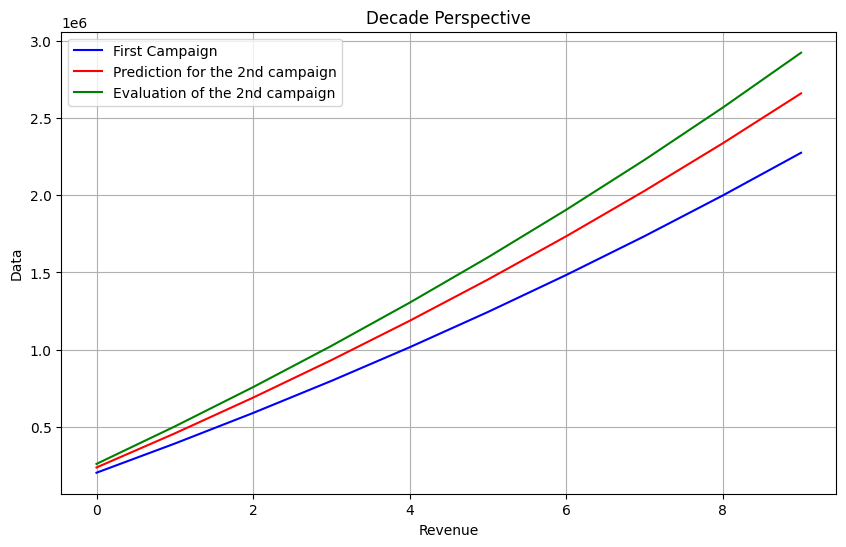

In [153]:
import matplotlib.pyplot as plt

input_dict = {
    'First Campaign':{
        'data': decade_perspective,
        'xaxis': range(year),
        'color': 'blue'
    },
    'Prediction for the 2nd campaign':{
        'data': decade_perspective_prediction,
        'xaxis': range(year),
        'color': 'red'
    },
    'Evaluation of the 2nd campaign':{
        'data': decade_perspective_evaluation,
        'xaxis': range(year),
        'color': 'green'
    }
}

def plot_line_graph(input_dict):
    plt.figure(figsize=(10, 6))
    
    for key, value in input_dict.items():
        data = value['data']
        xaxis = value['xaxis']
        color = value['color']
        
        plt.plot(xaxis, data, label=key, color=color)  
        
    plt.xlabel('Revenue')
    plt.ylabel('Data')
    plt.title('Decade Perspective')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_line_graph(input_dict)